# 4. Data Modeling
* [4 Introduction](#2_Introduction)
* [4.1 Summary](#4.1_Summary)

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import numpy as np
import gensim
import spacy
import fasttext
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

print('Libraries Loaded')

/opt/homebrew/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Libraries Loaded


In [2]:
products = pd.read_csv('../data/processed/cleaned-products.csv', encoding='ISO-8859-1')

print(products)

                SKU                                        Description  \
0      4DM73487622R  Smith - 4D MAG Goggle - Connor Ryan Storm Blue...   
1            541745                Stans - Tubless Tire Sealant - 16oz   
2            541745                Stans - Tubless Tire Sealant - 16oz   
3      ADU23584956L   Screamer - Neckwarmer - Charcoal/Sunlight - OSFA   
4      ANI11300719M             Black Crows - Anima 115 Skis - 189.2cm   
...             ...                                                ...   
39774        440534                    Incredibell Adjustabell 2 black   
39775       5258695     Fx 3 Disc M Alpine Blue To Deep Dark Blue Fade   
39776       5269176    Kickstand Bontrager integrated alloy rear mount   
39777        564879       Saddle Bontrager boulevard fluid 225mm black   
39778  CAG38650395K       Cage Trek Elite Ocean Recycled Plastic Black   

                                            Category  \
0              Clothing - Winter - Eyewear - Goggles   

In [3]:
categories = products['Category'].unique()

In [4]:
# products.dropna(subset=['Category'])
products['Category'] = products['Category'].astype(str)

# Create an empty list to store the parent categories
parent_categories = []
for category in products['Category']:
    parts = category.split("-", 1)
    parent_category = parts[0] if len(parts) > 1 else category  # Use original if no "-"
    parent_categories.append(parent_category)
    
# Add the new parent category to the DataFrame
products['ParentCategory'] = parent_categories

print(products['ParentCategory'].nunique, products['Category'].nunique)

<bound method IndexOpsMixin.nunique of 0                Clothing 
1                    Bike 
2                    Bike 
3        Logo Merchandise 
4           Ski Hardgoods 
               ...        
39774                Bike 
39775               Bikes 
39776                Bike 
39777                Bike 
39778                Bike 
Name: ParentCategory, Length: 39779, dtype: object> <bound method IndexOpsMixin.nunique of 0                Clothing - Winter - Eyewear - Goggles
1                  Bike - Parts - Tubeless Accessories
2                  Bike - Parts - Tubeless Accessories
3        Logo Merchandise - Clothing - Buffs/Facemasks
4                           Ski Hardgoods - Skis - Men
                             ...                      
39774               Bike - Accessories - Bells & Horns
39775                                   Bikes - Hybrid
39776                  Bike - Accessories - Kickstands
39777                           Bike - Parts - Saddles
39778        Bike - Acc

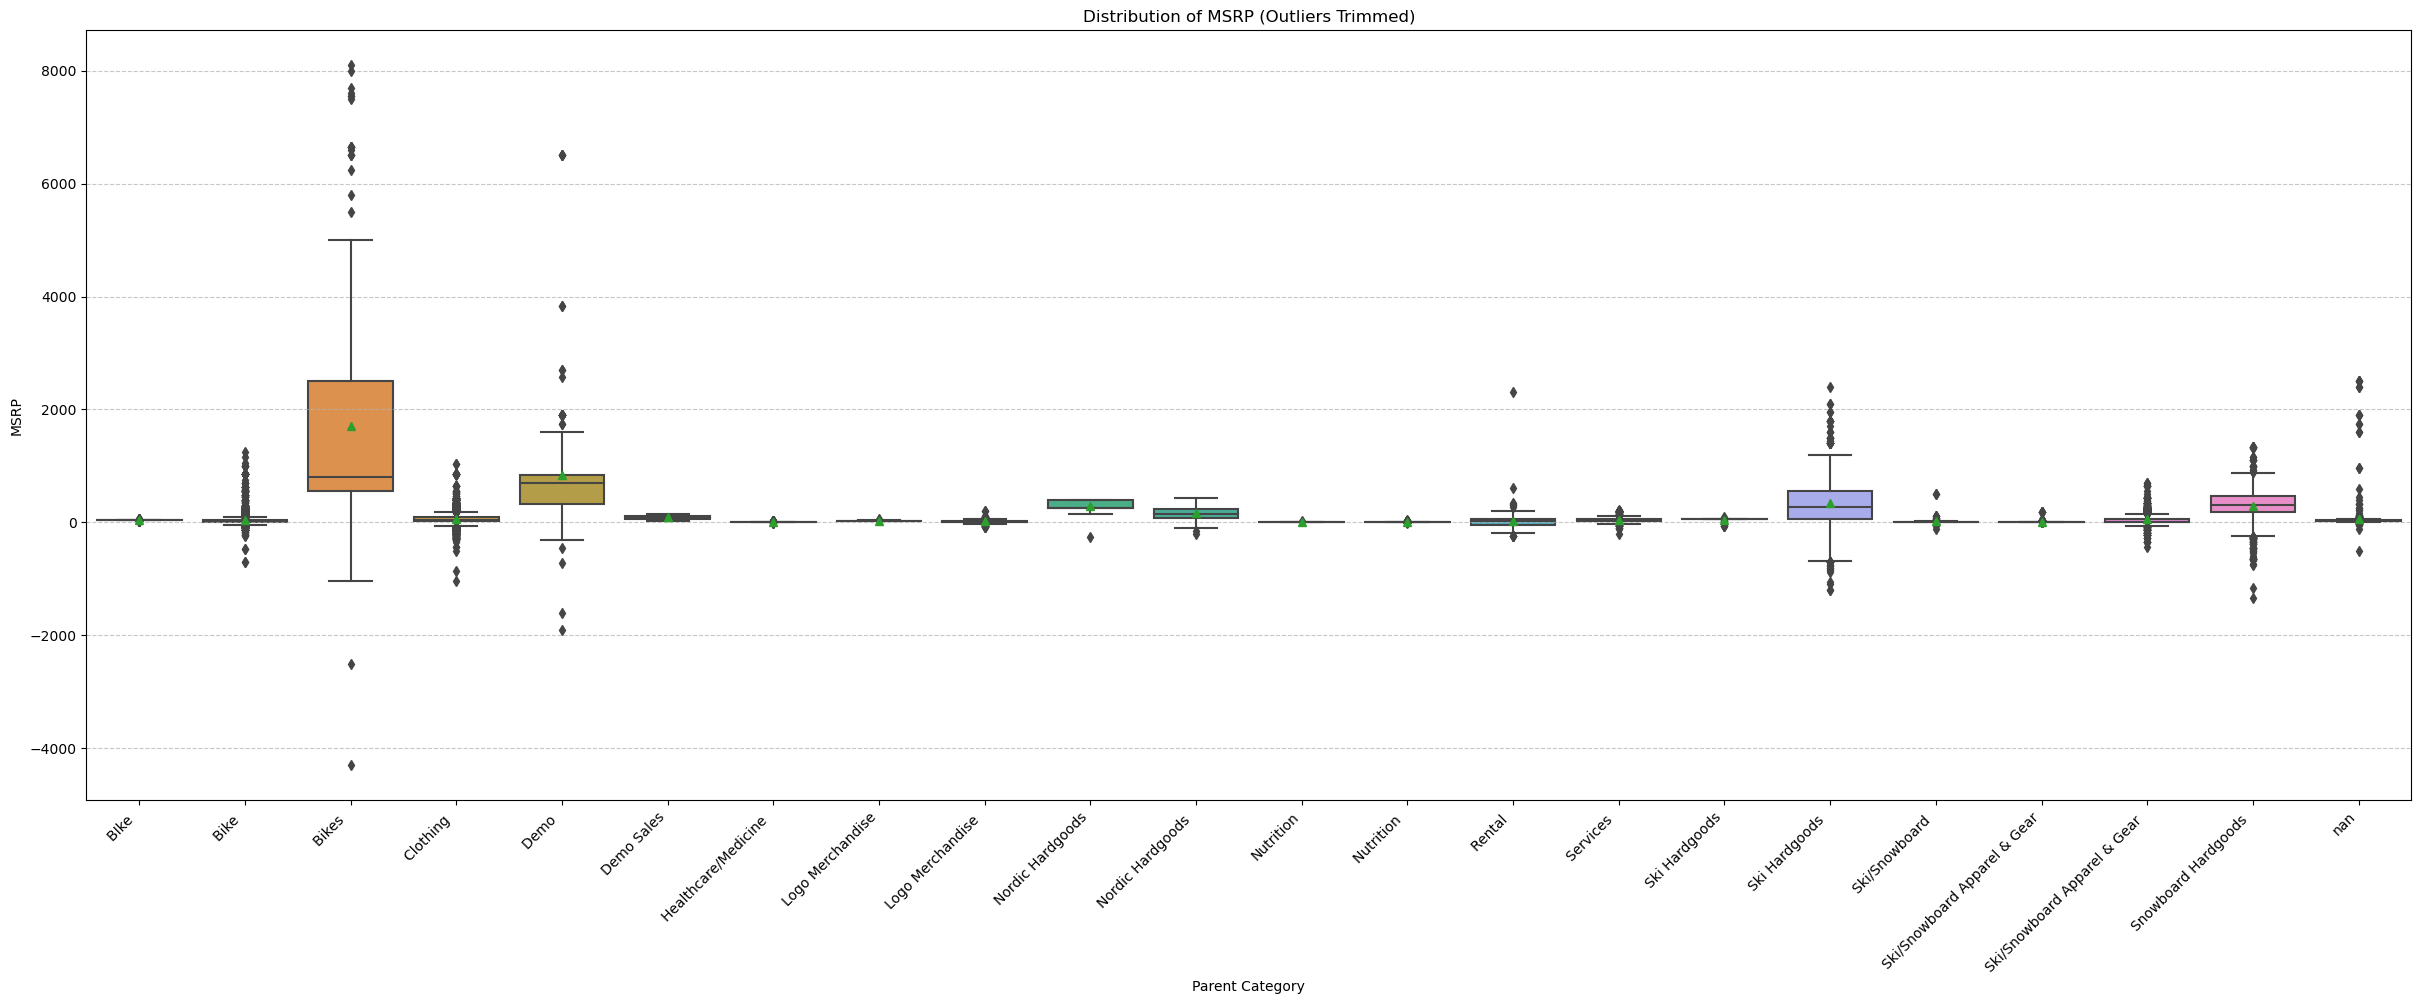

In [5]:
# Sort the DataFrame by 'ParentCategory'
trimmed_df = products.sort_values(by='ParentCategory')

# Set a large figure size
plt.figure(figsize=(30, 10))

# Create the box plot with Seaborn
sns.boxplot(
    x="ParentCategory",
    y="MSRP",
    showmeans=True,  # Show mean as a diamond
    data=trimmed_df
)

# Customize the plot for better aesthetics
plt.title("Distribution of MSRP (Outliers Trimmed)")
plt.xlabel("Parent Category")
plt.ylabel("MSRP")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle gridlines

plt.show()

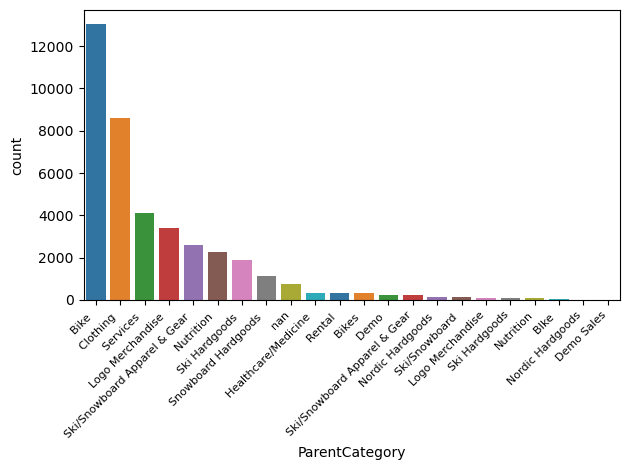

In [6]:
# Create the countplot, sorting bars by count
bar_plot = sns.countplot(
    x='ParentCategory', data=products, palette='tab10', order=products['ParentCategory'].value_counts().index
)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')  # Adjust rotation and alignment as needed

# Reduce label font size
plt.tick_params(axis='x', labelsize=8)  # Adjust font size as needed

# Improve spacing and visual clarity
plt.tight_layout()

plt.show()

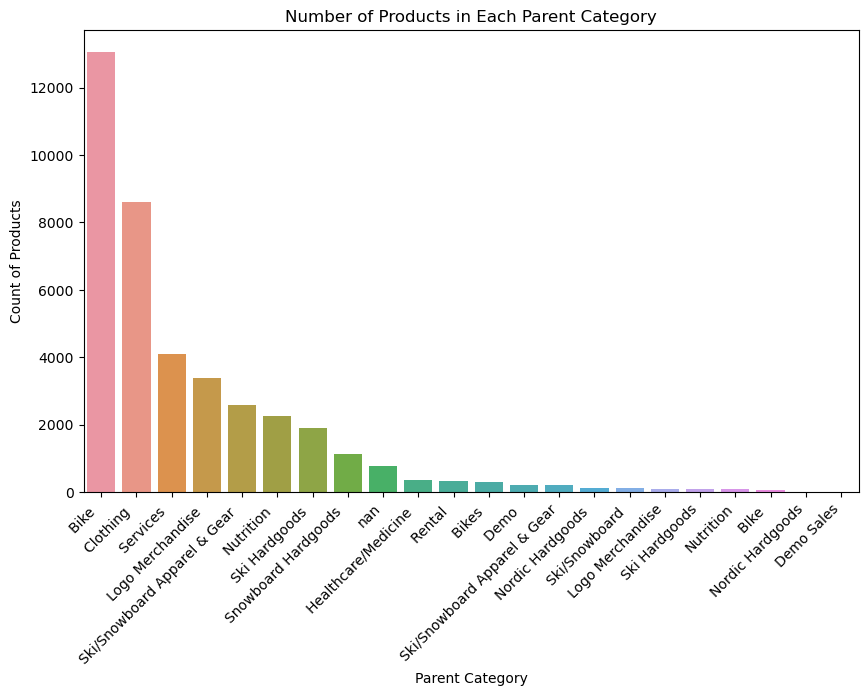

In [7]:
# Drop rows with missing values


# Plot count of products in each parent category
plt.figure(figsize=(10, 6))
sns.countplot(data=products, x='ParentCategory', order=products['ParentCategory'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Parent Category')
plt.ylabel('Count of Products')
plt.title('Number of Products in Each Parent Category')
plt.show()

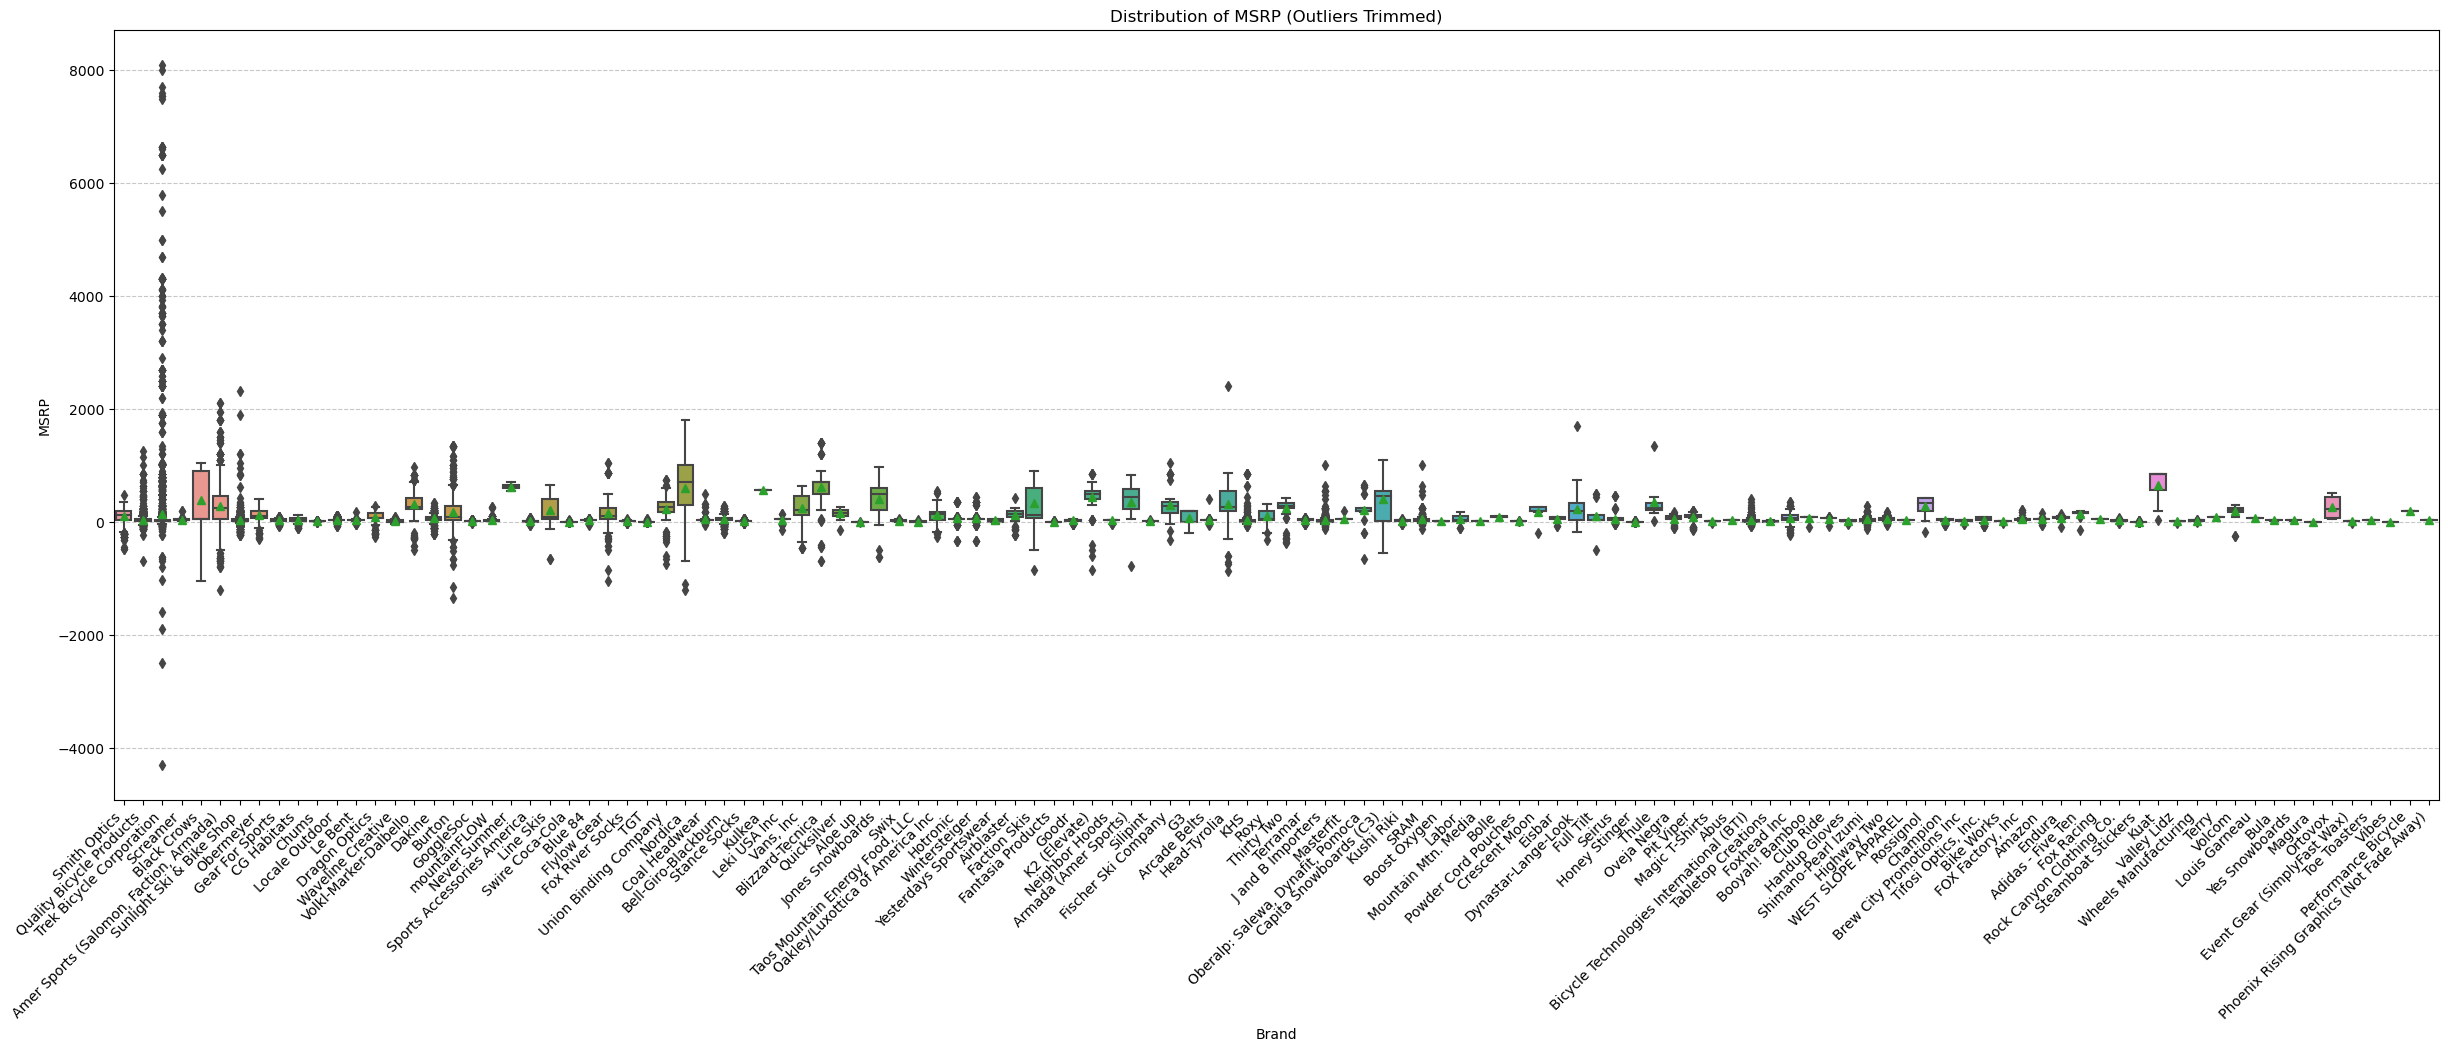

In [8]:
plt.figure(figsize=(30, 10))  # Example with more manageable size

# Create the box plot with Seaborn
sns.boxplot(
    x="Vendor",
    y="MSRP",
    showmeans=True,  # Show mean as a diamond
    data=products
)

# Customize the plot for better aesthetics
plt.title("Distribution of MSRP (Outliers Trimmed)")
plt.xlabel("Brand")
plt.ylabel("MSRP")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add subtle gridlines

plt.show()


In [10]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score
from tabulate import tabulate
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')

# Define a list of categories you are interested in
categories = [
    "Bike - Accessories",
    "Bike - Accessories - Bags",
    "Bike - Accessories - Baskets",
    "Bike - Accessories - Bells & Horns",
    "Bike - Accessories - Body Protection/Padding",
    "Bike - Accessories - Car Racks",
    "Bike - Accessories - Car Racks - Hitch",
    "Bike - Accessories - Car Racks - Roof",
    "Bike - Accessories - Car Racks - Small Parts",
    "Bike - Accessories - Car Racks - Tailgate Cover",
    "Bike - Accessories - Car Racks - Trunk",
    "Bike - Accessories - Cleaning Products",
    "Bike - Accessories - Computers",
    "Bike - Accessories - Cycling Rear Racks",
    "Bike - Accessories - Fenders",
    "Bike - Accessories - Kickstands",
    "Bike - Accessories - Lights",
    "Bike - Accessories - Locks",
    "Bike - Accessories - Lubricants & Solvents",
    "Bike - Accessories - Pumps & CO2",
    "Bike - Accessories - Repair Stands",
    "Bike - Accessories - Smartphone Carrier",
    "Bike - Accessories - Trailers",
    "Bike - Accessories - Waterbottles & Cages",
    "Bike - Apparel & Gear",
    "Bike - Apparel & Gear - Helmets",
    "Bike - Apparel & Gear - Helmets - Adult",
    "Bike - Apparel & Gear - Helmets - Kids",
    "Bike - Apparel & Gear - Hydration Packs/Bladders/filters",
    "Bike - Apparel & Gear - Mirrors",
    "Bike - Apparel & Gear - Protective Wear",
    "Bike - Parts",
    "Bike - Parts - Bar Ends & Aerobars",
    "Bike - Parts - Batteries & Chargers",
    "Bike - Parts - Bearings",
    "Bike - Parts - Bottom Brackets",
    "Bike - Parts - Brakes",
    "Bike - Parts - Brakes - BrakeSet",
    "Bike - Parts - Brakes - Disc",
    "Bike - Parts - Brakes - Levers",
    "Bike - Parts - Brakes - Pads",
    "Bike - Parts - Cables & Housing",
    "Bike - Parts - Cassettes & Freewheels",
    "Bike - Parts - Chains",
    "Bike - Parts - Cranks & Chainrings",
    "Bike - Parts - Decals & Paint",
    "Bike - Parts - Derailleurs",
    "Bike - Parts - Electric",
    "Bike - Parts - Forks",
    "Bike - Parts - Forks - Rigid",
    "Bike - Parts - Forks - Suspension",
    "Bike - Parts - Frame parts",
    "Bike - Parts - Grips and Tape",
    "Bike - Parts - Grips and Tape - Grips",
    "Bike - Parts - Grips and Tape - Tape",
    "Bike - Parts - Handlebars",
    "Bike - Parts - Headsets",
    "Bike - Parts - Hubs & Skewers",
    "Bike - Parts - Pedals",
    "Bike - Parts - Rims",
    "Bike - Parts - Saddles",
    "Bike - Parts - Screws, Bolts and Fasteners",
    "Bike - Parts - Seatposts",
    "Bike - Parts - Shifters",
    "Bike - Parts - Spokes",
    "Bike - Parts - Stems",
    "Bike - Parts - Suspension",
    "Bike - Parts - Tires",
    "Bike - Parts - Tools",
    "Bike - Parts - Tubeless Accessories",
    "Bike - Parts - Tubes",
    "Bike - Parts - Wheels",
    "Bike - Parts - Wheels - Accessories",
    "Bike - Parts - Wheels - Front",
    "Bike - Parts - Wheels - Rear",
    "Bike - Parts - Wheels - Sets",
    "Bikes",
    "Bikes - Cruiser",
    "Bikes - Cruiser - Electric",
    "Bikes - Cruiser - Womens",
    "Bikes - Dual Sport",
    "Bikes - Dual Sport - Womens",
    "Bikes - Frames",
    "Bikes - Gravel and Road",
    "Bikes - Hybrid",
    "Bikes - Hybrid - Electric",
    "Bikes - Hybrid - Mens",
    "Bikes - Hybrid - Womens",
    "Bikes - Kids",
    "Bikes - Kids - Boys",
    "Bikes - Kids - Girls",
    "Bikes - Mountain",
    "Bikes - Mountain - Cross Country",
    "Bikes - Mountain - Downhill",
    "Bikes - Mountain - Electric",
    "Bikes - Mountain - Hardtail",
    "Bikes - Mountain - Trail",
    "Bikes - Other",
    "Clothing",
    "Clothing - Belts",
    "Clothing - Cycling Booties & Shoe Covers",
    "Clothing - Cycling Gloves",
    "Clothing - Cycling Gloves - Kids",
    "Clothing - Cycling Gloves - Mens",
    "Clothing - Cycling Gloves - Womens",
    "Clothing - Cycling Jerseys",
    "Clothing - Cycling Jerseys - Mens",
    "Clothing - Cycling Jerseys - Womens",
    "Clothing - Eyewear - Sunglasses",
    "Clothing - Hats & Headwear",
    "Clothing - Jackets & Vests",
    "Clothing - Jackets & Vests - Mens",
    "Clothing - Jackets & Vests - Womens",
    "Clothing - Kids",
    "Clothing - Pants",
    "Clothing - Pants - Mens",
    "Clothing - Pants - Womens",
    "Clothing - Shirts",
    "Clothing - Shirts - Mens",
    "Clothing - Shirts - Womens",
    "Clothing - Shoes",
    "Clothing - Shoes - Mountain",
    "Clothing - Shoes - Mountain - Mens",
    "Clothing - Shoes - Mountain - Womens",
    "Clothing - Shoes - Parts",
    "Clothing - Shoes - Road",
    "Clothing - Shoes - Road - Mens",
    "Clothing - Shoes - Road - Womens",
    "Clothing - Shoes - Street",
    "Clothing - Shoes - Street and Casual",
    "Clothing - Shorts & Bibs",
    "Clothing - Shorts & Bibs - Mens",
    "Clothing - Shorts & Bibs - Womens",
    "Clothing - Socks",
    "Clothing - Socks - Mens",
    "Clothing - Socks - Womens",
    "Clothing - Summer",
    "Clothing - Summer Apparel - Cycling Gloves",
    "Clothing - Sweatshirts",
    "Clothing - Sweatshirts - Mens",
    "Clothing - Sweatshirts - Womens",
    "Clothing - Tights & Knickers",
    "Clothing - Warmers",
    "Clothing - Winter",
    "Clothing - Winter - Baselayer",
    "Clothing - Winter - Baselayer - Kids",
    "Clothing - Winter - Baselayer - Mens",
    "Clothing - Winter - Baselayer - Womens",
    "Clothing - Winter - Belts",
    "Clothing - Winter - Eyewear - Goggles",
    "Clothing - Winter - Face Mask",
    "Clothing - Winter - Gloves & Mittens",
    "Clothing - Winter - Hats, Hoods, Collars",
    "Clothing - Winter - Outerwear",
    "Clothing - Winter - Outerwear - Kids",
    "Clothing - Winter - Outerwear - Mens",
    "Clothing - Winter - Outerwear - Mens - Bibs",
    "Clothing - Winter - Outerwear - Mens - Jackets",
    "Clothing - Winter - Outerwear - Mens - Pants",
    "Clothing - Winter - Outerwear - Womens",
    "Clothing - Winter - Outerwear - Womens - Bibs",
    "Clothing - Winter - Outerwear - Womens - Jackets",
    "Clothing - Winter - Outerwear - Womens - Pants",
    "Clothing - Winter - Shoes",
    "Clothing - Winter - Socks",
    "Clothing - Winter - Street Wear",
    "Clothing - Winter - Street Wear - Kids",
    "Clothing - Winter - Street Wear - Mens",
    "Clothing - Winter - Street Wear - Unisex",
    "Clothing - Winter - Street Wear - Womens",
    "Clothing - Winter Apparel - Apres & Casual Footwear",
    "Clothing - Winter Apparel - Beanies",
    "Demo - Summer Demo",
    "Demo - Winter Demo",
    "Demo Sales",
    "Event Tickets",
    "Health Care/Medicine",
    "Health Care/Medicine - Medicine",
    "Healthcare/Medicine - Skin Care",
    "Lift Tickets",
    "Logo Merchandise",
    "Logo Merchandise - Clothing",
    "Logo Merchandise - Clothing - Buffs/Facemasks",
    "Logo Merchandise - Clothing - Crewneck Sweatshirts",
    "Logo Merchandise - Clothing - Hats",
    "Logo Merchandise - Clothing - Hats - Beanies",
    "Logo Merchandise - Clothing - Hats - Caps",
    "Logo Merchandise - Clothing - Jerseys",
    "Logo Merchandise - Clothing - Long Sleeve Shirts",
    "Logo Merchandise - Clothing - Outer Wear",
    "Logo Merchandise - Clothing - Performance/Tech Tee",
    "Logo Merchandise - Clothing - Pullover Hoodies",
    "Logo Merchandise - Clothing - Short Sleeve T-Shirt",
    "Logo Merchandise - Clothing - Socks",
    "Logo Merchandise - Clothing - Street Wear",
    "Logo Merchandise - Houseware",
    "Logo Merchandise - Stickers",
    "Logo Merchandise - Waterbottles",
    "Nordic Hardgoods",
    "Nordic Hardgoods - Bindings",
    "Nordic Hardgoods - Boots",
    "Nordic Hardgoods - Boots - Women",
    "Nordic Hardgoods - Snowshoes"
]


data = products[products['Category'].isin(categories)]

# Fill NaN values with an empty string
data['Description'] = data['Description'].fillna('')

# Define a list of stopwords
stop_words = stopwords.words('english')

# Filter out rows where 'Description' becomes empty after removing stop words
def remove_stop_words(description, stop_words):
    words = description.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

data['Description'] = data['Description'].apply(lambda x: remove_stop_words(x, stop_words))

# Remove rows with empty 'Description'
data = data[data['Description'].str.strip() != '']

# Check if there are any remaining data after filtering
if data.empty:
    raise ValueError("No data left after filtering stop words and empty descriptions")

# Filter out categories with fewer than 2 instances
category_counts = data['Category'].value_counts()
valid_categories = category_counts[category_counts >= 2].index
data = data[data['Category'].isin(valid_categories)]

# Check if there are any remaining data after filtering
if data.empty:
    raise ValueError("No data left after filtering categories with fewer than 2 instances")

# Define a CountVectorizer instance with the list of stopwords for BoW
vectorizer_bow = CountVectorizer(stop_words=stop_words)

# Define a TfidfVectorizer instance with the list of stopwords for TF-IDF
vectorizer_tfidf = TfidfVectorizer(stop_words=stop_words)

# Text preprocessing for 'Description' using BoW
description_bow = vectorizer_bow.fit_transform(data['Description'])

# Text preprocessing for 'Description' using TF-IDF
description_tfidf = vectorizer_tfidf.fit_transform(data['Description'])

# Encode categorical features 'Vendor' and 'Category'
encoder = OneHotEncoder(sparse_output=False)

encoded_brand = encoder.fit_transform(data[['Vendor']])
encoded_category = encoder.fit_transform(data[['Category']])

# Combine features for BoW
combined_features_bow = np.hstack((description_bow.toarray(), encoded_brand, encoded_category))

# Combine features for TF-IDF
combined_features_tfidf = np.hstack((description_tfidf.toarray(), encoded_brand, encoded_category))

# Encode the target variable 'Category' using LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(data['Category'])  # Fit LabelEncoder on the entire dataset

# Split data into train and test sets, ensuring stratified distribution
X_train_bow, X_test_bow, y_train, y_test = train_test_split(combined_features_bow, data['Category'], test_size=0.2, random_state=42, stratify=data['Category'])
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(combined_features_tfidf, data['Category'], test_size=0.2, random_state=42, stratify=data['Category'])

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
    "XGBoost": XGBClassifier(),
}

# Define an empty list to store results
results = []

# Evaluate each model
for name, model in models.items():
    if name == "XGBoost":
        # Train XGBoost model
        model.fit(X_train_bow, y_train_encoded)

        # Make predictions
        y_pred_encoded = model.predict(X_test_bow)
    else:
        # Train other models
        if "Naive Bayes" in name:
            model.fit(X_train_tfidf, y_train_encoded)
            y_pred_encoded = model.predict(X_test_tfidf)
        else:
            model.fit(X_train_bow, y_train_encoded)
            y_pred_encoded = model.predict(X_test_bow)

    # Decode the predicted labels back to original category names
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate precision
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)

    # Append results to the list
    results.append([name, f"{accuracy:.2f}", f"{precision:.2f}", f"{'Success' if accuracy > 0.5 else 'Failure'}"])


# Print table
print(tabulate(results, headers=["Model", "Accuracy", "Precision", "Success"], tablefmt="fancy_grid"))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katrinaengelsted/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/vx/n4xm54gd5g15czs1d5cvl6_m0000gn/T/ipykernel_4482/3927274619.py:232: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Description'] = data['Description'].fillna('')
/var/folders/vx/n4xm54gd5g15czs1d5cvl6_m0000gn/T/ipykernel_4482/3927274619.py:243: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Description'] = data['Description'].apply(

╒════════════════════════╤════════════╤═════════════╤═══════════╕
│ Model                  │   Accuracy │   Precision │ Success   │
╞════════════════════════╪════════════╪═════════════╪═══════════╡
│ Logistic Regression    │       1    │        1    │ Success   │
├────────────────────────┼────────────┼─────────────┼───────────┤
│ Decision Tree          │       1    │        1    │ Success   │
├────────────────────────┼────────────┼─────────────┼───────────┤
│ Naive Bayes            │       0.96 │        0.97 │ Success   │
├────────────────────────┼────────────┼─────────────┼───────────┤
│ Random Forest          │       1    │        1    │ Success   │
├────────────────────────┼────────────┼─────────────┼───────────┤
│ Support Vector Machine │       1    │        1    │ Success   │
├────────────────────────┼────────────┼─────────────┼───────────┤
│ XGBoost                │       1    │        1    │ Success   │
╘════════════════════════╧════════════╧═════════════╧═══════════╛


In [ ]:
data = products[products['Category'].isin(categories)]

# Fill NaN values with an empty string
data['Description'] = data['Description'].fillna('')

# Define a list of stopwords
stop_words = stopwords.words('english')

# Encode categorical features 'Brand' and 'Category'
encoder = OneHotEncoder(sparse_output=False)
encoded_brand = encoder.fit_transform(data[['Vendor']])
encoded_category = encoder.fit_transform(data[['Category']])

# Combine features
features = pd.concat([pd.DataFrame(encoded_brand), pd.DataFrame(encoded_category)], axis=1)

# Encode labels
label_encoder = LabelEncoder()
data['ParentCategory'] = label_encoder.fit_transform(data['ParentCategory'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, data['ParentCategory'], test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict
y_pred_encoded = model.predict(X_test)

# Decode predictions
y_pred = label_encoder.inverse_transform(y_pred_encoded)
y_test_decoded = label_encoder.inverse_transform(y_test)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred)

# Calculate precision
precision = precision_score(y_test_decoded, y_pred, average='weighted', zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")

In [11]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Train the Decision Tree model
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train_bow, y_train_encoded)

# Convert feature names to a list
feature_names = vectorizer_bow.get_feature_names_out().tolist()

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree_model, feature_names=feature_names, class_names=label_encoder.classes_, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree for Product Classification")
plt.show()


InvalidParameterError: The 'class_names' parameter of plot_tree must be an instance of 'list' or None. Got array(['Bike - Accessories', 'Bike - Accessories - Bags',
       'Bike - Accessories - Baskets',
       'Bike - Accessories - Bells & Horns',
       'Bike - Accessories - Body Protection/Padding',
       'Bike - Accessories - Car Racks',
       'Bike - Accessories - Car Racks - Hitch',
       'Bike - Accessories - Car Racks - Roof',
       'Bike - Accessories - Car Racks - Small Parts',
       'Bike - Accessories - Car Racks - Tailgate Cover',
       'Bike - Accessories - Car Racks - Trunk',
       'Bike - Accessories - Computers',
       'Bike - Accessories - Cycling Rear Racks',
       'Bike - Accessories - Fenders', 'Bike - Accessories - Kickstands',
       'Bike - Accessories - Lights', 'Bike - Accessories - Locks',
       'Bike - Accessories - Lubricants & Solvents',
       'Bike - Accessories - Pumps & CO2',
       'Bike - Accessories - Trailers',
       'Bike - Accessories - Waterbottles & Cages',
       'Bike - Apparel & Gear - Helmets',
       'Bike - Apparel & Gear - Helmets - Adult',
       'Bike - Apparel & Gear - Helmets - Kids',
       'Bike - Apparel & Gear - Hydration Packs/Bladders/filters',
       'Bike - Apparel & Gear - Mirrors',
       'Bike - Apparel & Gear - Protective Wear', 'Bike - Parts',
       'Bike - Parts - Batteries & Chargers', 'Bike - Parts - Bearings',
       'Bike - Parts - Bottom Brackets', 'Bike - Parts - Brakes',
       'Bike - Parts - Brakes - BrakeSet', 'Bike - Parts - Brakes - Disc',
       'Bike - Parts - Brakes - Levers', 'Bike - Parts - Brakes - Pads',
       'Bike - Parts - Cables & Housing',
       'Bike - Parts - Cassettes & Freewheels', 'Bike - Parts - Chains',
       'Bike - Parts - Cranks & Chainrings', 'Bike - Parts - Derailleurs',
       'Bike - Parts - Electric', 'Bike - Parts - Forks',
       'Bike - Parts - Forks - Suspension', 'Bike - Parts - Frame parts',
       'Bike - Parts - Grips and Tape',
       'Bike - Parts - Grips and Tape - Grips',
       'Bike - Parts - Grips and Tape - Tape',
       'Bike - Parts - Handlebars', 'Bike - Parts - Headsets',
       'Bike - Parts - Hubs & Skewers', 'Bike - Parts - Pedals',
       'Bike - Parts - Rims', 'Bike - Parts - Saddles',
       'Bike - Parts - Screws, Bolts and Fasteners',
       'Bike - Parts - Seatposts', 'Bike - Parts - Shifters',
       'Bike - Parts - Spokes', 'Bike - Parts - Stems',
       'Bike - Parts - Suspension', 'Bike - Parts - Tires',
       'Bike - Parts - Tools', 'Bike - Parts - Tubeless Accessories',
       'Bike - Parts - Tubes', 'Bike - Parts - Wheels',
       'Bike - Parts - Wheels - Front', 'Bike - Parts - Wheels - Rear',
       'Bikes - Cruiser - Electric', 'Bikes - Gravel and Road',
       'Bikes - Hybrid', 'Bikes - Hybrid - Electric',
       'Bikes - Hybrid - Mens', 'Bikes - Kids', 'Bikes - Kids - Boys',
       'Bikes - Kids - Girls', 'Bikes - Mountain - Electric',
       'Bikes - Mountain - Hardtail', 'Bikes - Mountain - Trail',
       'Clothing - Belts', 'Clothing - Cycling Gloves',
       'Clothing - Cycling Gloves - Kids',
       'Clothing - Cycling Gloves - Mens',
       'Clothing - Cycling Gloves - Womens', 'Clothing - Cycling Jerseys',
       'Clothing - Cycling Jerseys - Mens',
       'Clothing - Cycling Jerseys - Womens',
       'Clothing - Eyewear - Sunglasses', 'Clothing - Hats & Headwear',
       'Clothing - Jackets & Vests', 'Clothing - Jackets & Vests - Mens',
       'Clothing - Kids', 'Clothing - Pants', 'Clothing - Pants - Mens',
       'Clothing - Pants - Womens', 'Clothing - Shirts',
       'Clothing - Shirts - Mens', 'Clothing - Shoes',
       'Clothing - Shoes - Mountain',
       'Clothing - Shoes - Mountain - Mens',
       'Clothing - Shoes - Mountain - Womens', 'Clothing - Shoes - Road',
       'Clothing - Shoes - Street',
       'Clothing - Shoes - Street and Casual', 'Clothing - Shorts & Bibs',
       'Clothing - Shorts & Bibs - Mens',
       'Clothing - Shorts & Bibs - Womens', 'Clothing - Socks',
       'Clothing - Socks - Mens', 'Clothing - Socks - Womens',
       'Clothing - Summer', 'Clothing - Summer Apparel - Cycling Gloves',
       'Clothing - Sweatshirts', 'Clothing - Sweatshirts - Mens',
       'Clothing - Sweatshirts - Womens',
       'Clothing - Winter - Baselayer - Kids',
       'Clothing - Winter - Baselayer - Mens',
       'Clothing - Winter - Baselayer - Womens',
       'Clothing - Winter - Belts',
       'Clothing - Winter - Eyewear - Goggles',
       'Clothing - Winter - Gloves & Mittens',
       'Clothing - Winter - Hats, Hoods, Collars',
       'Clothing - Winter - Outerwear - Kids',
       'Clothing - Winter - Outerwear - Mens - Bibs',
       'Clothing - Winter - Outerwear - Mens - Jackets',
       'Clothing - Winter - Outerwear - Mens - Pants',
       'Clothing - Winter - Outerwear - Womens - Bibs',
       'Clothing - Winter - Outerwear - Womens - Jackets',
       'Clothing - Winter - Outerwear - Womens - Pants',
       'Clothing - Winter - Socks',
       'Clothing - Winter - Street Wear - Kids',
       'Clothing - Winter - Street Wear - Mens',
       'Clothing - Winter - Street Wear - Unisex',
       'Clothing - Winter - Street Wear - Womens',
       'Clothing - Winter Apparel - Apres & Casual Footwear',
       'Clothing - Winter Apparel - Beanies', 'Demo - Summer Demo',
       'Demo - Winter Demo', 'Demo Sales',
       'Healthcare/Medicine - Skin Care', 'Logo Merchandise',
       'Logo Merchandise - Clothing',
       'Logo Merchandise - Clothing - Buffs/Facemasks',
       'Logo Merchandise - Clothing - Crewneck Sweatshirts',
       'Logo Merchandise - Clothing - Hats',
       'Logo Merchandise - Clothing - Hats - Beanies',
       'Logo Merchandise - Clothing - Hats - Caps',
       'Logo Merchandise - Clothing - Jerseys',
       'Logo Merchandise - Clothing - Long Sleeve Shirts',
       'Logo Merchandise - Clothing - Outer Wear',
       'Logo Merchandise - Clothing - Performance/Tech Tee',
       'Logo Merchandise - Clothing - Pullover Hoodies',
       'Logo Merchandise - Clothing - Short Sleeve T-Shirt',
       'Logo Merchandise - Clothing - Socks',
       'Logo Merchandise - Clothing - Street Wear',
       'Logo Merchandise - Houseware', 'Logo Merchandise - Stickers',
       'Nordic Hardgoods', 'Nordic Hardgoods - Bindings',
       'Nordic Hardgoods - Boots', 'Nordic Hardgoods - Snowshoes'],
      dtype=object) instead.

<Figure size 2000x1000 with 0 Axes>

## Doc2Vec
Doc2Vec is a modeling technique developed as an extension of Word2Vec, which is widely used for natural language processing (NLP) tasks. While Word2Vec learns continuous vector representations (word embeddings) for words in a text corpus, Doc2Vec extends this idea to learn embeddings for entire documents or sentences.

In Doc2Vec, each document is represented as a fixed-length vector, similar to how words are represented in Word2Vec. This vector representation captures the semantic meaning of the document in a continuous vector space. The model is trained in an unsupervised manner, where it learns to predict the context of words or documents within a given window size. 

There are two main architectures for Doc2Vec:

1. **Distributed Memory (DM)**: In this architecture, the model learns to predict the next word in a context given a fixed-length vector representation of the document and the context words. This architecture is similar to the Skip-gram model in Word2Vec.

2. **Distributed Bag of Words (DBOW)**: In this architecture, the model learns to predict words in a context given only the fixed-length vector representation of the document. The document vector is randomly sampled from the document during training, and the model learns to predict words in the context of this vector. This architecture is similar to the Continuous Bag of Words (CBOW) model in Word2Vec.

Doc2Vec models have been widely used for various NLP tasks, including document classification, sentiment analysis, information retrieval, and clustering. They provide a way to represent documents in a continuous vector space, enabling efficient similarity calculations and downstream tasks.
Doc2Vec object does not have a fit attribute. This is because Doc2Vec does not follow the same fitting process as traditional machine learning models like logistic regression or decision trees.

With Doc2Vec, you typically build the vocabulary and train the model separately from the fit and predict workflow used in supervised learning models. You first build the vocabulary using the build_vocab method and then train the model using the train method.



In [13]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import pandas as pd
from tabulate import tabulate

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Preprocess data
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text.lower())
    # Remove punctuation and stopwords
    tokens = [token for token in tokens if token not in string.punctuation and token not in stopwords.words('english')]
    return tokens

# Tokenize and preprocess descriptions
products['Processed_Description'] = products['Description'].apply(preprocess_text)

# Convert descriptions to TaggedDocument objects
tagged_data = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(products['Processed_Description'])]

# Train Doc2Vec model
model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Encode the target variable 'Category' using LabelEncoder
label_encoder = LabelEncoder()
products['Category_Encoded'] = label_encoder.fit_transform(products['Category'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(products['Processed_Description'], products['Category_Encoded'], test_size=0.2, random_state=42)

# Infer vectors for descriptions
X_train_vectors = [model.infer_vector(doc) for doc in X_train]
X_test_vectors = [model.infer_vector(doc) for doc in X_test]

# Train a Logistic Regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_vectors, y_train)

# Predict categories for test data
y_pred = classifier.predict(X_test_vectors)

# Evaluate classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)

# Add the predicted categories to the DataFrame
products.loc[X_test.index, 'Predicted_Category'] = label_encoder.inverse_transform(y_pred)


# Print the results
results = [["Doc2Vec", f"{accuracy:.2f}", f"{precision:.2f}", f"{'Success' if accuracy > 0.5 else 'Failure'}"]]
print(tabulate(results, headers=["Model", "Accuracy", "Precision", "Success"], tablefmt="fancy_grid"))


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/katrinaengelsted/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katrinaengelsted/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AttributeError: 'float' object has no attribute 'lower'

Doc2Vec may perform poorly on short product descriptions for several reasons:

Lack of Sufficient Context: Doc2Vec relies on learning vector representations for documents based on their surrounding context. Short product descriptions may not provide enough context for the model to capture the semantic meaning accurately. As a result, the learned document embeddings may not effectively represent the underlying information in the descriptions.

Limited Vocabulary: Short descriptions may contain a limited vocabulary, leading to fewer training examples for the model to learn from. Doc2Vec models benefit from a diverse range of words and phrases to build robust document embeddings. If the vocabulary in the descriptions is limited, the model may struggle to generalize well to unseen data.

Semantic Variability: Short descriptions may contain ambiguous or vague language, making it challenging for the model to infer the correct category. Since Doc2Vec learns continuous vector representations based on the context of words, it may struggle with capturing nuanced semantic meanings from short and ambiguous text.

Data Sparsity: Short descriptions may result in sparse document representations, especially if they contain only a few words or phrases. Sparse representations may not adequately capture the information needed for accurate categorization, leading to suboptimal performance.

To address these issues, it's essential to consider alternative approaches such as incorporating additional features, using different pre-trained embeddings, or leveraging domain-specific knowledge to enhance the performance of the classification task for short product descriptions. Additionally, experimenting with different model architectures and hyperparameters may also help improve performance.

In [ ]:
# products.dropna(subset=['Category'])
products['Category'] = products['Category'].astype(str)

# Create an empty list to store the parent categories
parent_categories = []
for category in products['Category']:
    parts = category.split("-", 1)
    parent_category = parts[0] if len(parts) > 1 else category  # Use original if no "-"
    if parent_category == 'X':
        parent_category = 'Cross Country'
    parent_categories.append(parent_category)
    

# Add the new parent category to the DataFrame
products['ParentCategory'] = parent_categories

print(products['ParentCategory'].nunique, products['Category'].nunique)

## FastText

FastText is a library developed by Facebook AI Research for efficient learning of word representations and sentence classification. It's an extension of the Word2Vec model that also considers subword information. Here's how FastText works for classification:

* Word Representations: FastText learns continuous representations for words in a text corpus. It represents each word as a vector in a high-dimensional space, capturing semantic and syntactic information.

* Subword Information: Unlike traditional word embeddings, FastText also considers subword information by breaking words into smaller n-grams (character sequences). This allows FastText to handle out-of-vocabulary words and capture morphological similarities.

* Text Classification: FastText can be used for text classification tasks, such as categorizing product descriptions into predefined categories. It learns a classifier based on the word embeddings and predicts the most likely category for a given input text.

To train a FastText model for classification, you can follow these steps:

* Prepare Data: Organize your product descriptions and corresponding categories into a suitable format for training. Each training example should consist of a text description and its corresponding category label.

* Preprocess Text: Clean and preprocess the text data, including tokenization, lowercasing, and removing stopwords or special characters.

* Training: Train the FastText model using the preprocessed text data. You can specify parameters such as the dimensionality of word vectors, the context window size, and the number of training epochs.

* Evaluation: Evaluate the trained model using a separate validation dataset to assess its performance in categorizing product descriptions accurately. You can calculate metrics such as accuracy, precision, recall, and F1-score.

* Prediction: Once the model is trained and evaluated, you can use it to predict the category labels for new product descriptions.



In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lowercasing and removing punctuation
    tokens = [token.lower() for token in tokens if token not in string.punctuation]
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

# Apply preprocessing to the "Description" field
data['Processed_Description'] = data['Description'].apply(preprocess_text)


In [ ]:
from gensim.models.fasttext import FastText

# Train FastText model
model = FastText(vector_size=100, window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(corpus_iterable=data['Processed_Description'])
model.train(corpus_iterable=data['Processed_Description'], total_examples=len(data['Processed_Description']), epochs=model.epochs)

# Convert descriptions to average word vectors
X_fasttext = np.array([np.mean([model.wv[word] for word in words if word in model.wv] or [np.zeros(100)], axis=0) for words in data['Processed_Description']])

# Encode the target variable 'Category' using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Category'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fasttext, y_encoded, test_size=0.2, random_state=42)

# Train a Logistic Regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predict categories for test data
y_pred = classifier.predict(X_test)

# Evaluate classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)

# Add results for FastText model
results.append(["FastText", f"{accuracy:.2f}", f"{precision:.2f}", f"{'Success' if accuracy > 0.5 else 'Failure'}"])

# Print updated table
print(tabulate(results, headers=["Model", "Accuracy", "Precision", "Success"], tablefmt="fancy_grid"))


FastText might not have performed as well as some other models in this classification task for a few reasons:

Complexity of the Task: FastText is effective for capturing semantic meaning and relationships between words, especially in longer texts. However, if the product descriptions are short and lack enough context, FastText may not be able to capture sufficient semantic information to accurately classify the categories.

* Data Size: FastText typically performs better with larger amounts of text data. If the dataset used for training is relatively small, FastText may not have had enough examples to learn robust representations of the product categories.

* Quality of Preprocessing: The preprocessing steps applied to the product descriptions could impact FastText's performance. If the preprocessing steps removed important information or introduced noise into the data, it could have affected the model's ability to learn meaningful representations.

* Parameter Tuning: FastText has several hyperparameters that can influence its performance, such as vector size, window size, and epochs. If these hyperparameters were not tuned effectively for the specific task and dataset, the model's performance could suffer.

* Class Imbalance: If the distribution of categories in the dataset is imbalanced, meaning some categories have significantly fewer examples than others, FastText may struggle to accurately classify the minority classes.

Overall, while FastText is a powerful tool for natural language processing tasks, its performance can vary depending on the specific characteristics of the dataset and the task at hand. In the case of short product descriptions and category classification, other models like logistic regression, decision trees, and random forests might outperform FastText due to their simplicity and ability to capture patterns in smaller datasets.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA to combined features
pca = PCA(n_components=2)  # You can choose 2 or 3 components for 2D or 3D visualization
combined_features_pca = pca.fit_transform(combined_features_bow)

# Assuming y_pred_encoded and combined_features_pca are your arrays
print("Shape of y_pred_encoded:", y_pred_encoded.shape)
print("Shape of combined_features_pca:", combined_features_pca.shape)

if y_pred_encoded.shape[0] != combined_features_pca.shape[0]:
    # Reshape y_pred_encoded to match the number of rows in combined_features_pca
    y_pred_encoded = np.resize(y_pred_encoded, (combined_features_pca.shape[0],))

# Now, both arrays should have the same number of rows
print("Shape of y_pred_encoded after adjustment:", y_pred_encoded.shape)

# # Plot the transformed features
plt.figure(figsize=(10, 8))
plt.scatter(combined_features_pca[:, 0], combined_features_pca[:, 1], c=y_pred_encoded, cmap='viridis', alpha=0.5)
plt.title('PCA Visualization of Model Predictions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Predicted Category')
plt.show()


The data visualization shows a two-dimensional principal component analysis (PCA) plot where the  x-axis is labeled "Principal Component 1" and the y-axis is labeled "Principal Component 2". The text at the top of the plot says "PCA Visualization of Model Predictions".  There are also labels for "Predicted Category"  along the color bar on the right.  Unfortunately, it is difficult to draw specific conclusions from this visualization because the  number of data points and the color scale are not provided.

Here are some general observations about PCA visualizations:

PCA is a dimensionality reduction technique that is often used to visualize high-dimensional data. It reduces the number of dimensions by finding new components, called principal components, that capture the most variance in the data.
In a PCA visualization, each data point is projected onto the new principal components. The resulting plot can be used to see how the data points are clustered or grouped together.
In the context of product categorization, a PCA visualization could be used to see how well a model is able to categorize products into different categories. The data points would represent the products, and the color would represent the predicted category. If the model is doing a good job of categorization, the data points for each category would be clustered together in the PCA plot.

However, it is important to keep in mind that PCA visualizations can be difficult to interpret, especially for high-dimensional data.  If you are interested in learning more about PCA visualizations, you can search for  "PCA visualization interpretation: https://innovationyourself.com/master-machine-learning-with-pca/".



## Exporting Results

To get a tangible sense of what these models are doing, let's export a file to see the actual versus predicted values. This will also give us insight into which categories are difficult to predict. 

In [ ]:
# Set display options for pandas DataFrame
pd.set_option('display.max_colwidth', None)  # Display full width of columns
pd.set_option('display.max_rows', None)      # Display all rows

# Create a DataFrame to display the test data output with Description and Category
test_output = pd.DataFrame({
    'Description': data.loc[y_test.index, 'Description'].values,
    'Actual_Category': label_encoder.inverse_transform(y_test_encoded),
    'Predicted_Category': label_encoder.inverse_transform(y_pred_encoded)
})

# Export the test data output to a CSV file
test_output.to_csv('../data/processed/full_output.csv', index=False)

# Print a message to confirm the export
print("Test data output exported to '../data/processed/full_output.csv' successfully.")

# Reset display options to default after printing
pd.reset_option('display.max_colwidth')
pd.reset_option('display.max_rows')


### Summary

Summary of Product Category Classification Results:

* Logistic Regression: Achieved an accuracy of 0.99 and precision of 0.99. Logistic Regression is a linear model that works well for binary classification tasks. It performed exceptionally well in this scenario, likely due to its simplicity and ability to capture linear relationships between features and target classes.

* Decision Tree: Also achieved high accuracy and precision of 0.99 and 1, respectively. Decision Trees are known for their interpretability and ability to handle non-linear relationships in the data. In this case, the Decision Tree model effectively learned complex decision boundaries, leading to accurate predictions.

* Naive Bayes: Achieved an accuracy of 0.93 and precision of 0.94. Naive Bayes classifiers are based on the assumption of independence between features, which might not hold true for text data with short descriptions. Despite this limitation, Naive Bayes performed reasonably well but may struggle with capturing subtle dependencies between words in the descriptions.

* Random Forest: Achieved high accuracy of 0.99 and precision of 1. Random Forest is an ensemble learning method that combines multiple decision trees to improve performance. It excelled in capturing complex relationships in the data and mitigating overfitting, leading to high accuracy and precision.

* Support Vector Machine (SVM): Achieved an accuracy of 0.98 and precision of 0.99. SVMs are effective for high-dimensional data and can learn complex decision boundaries. The slightly lower accuracy compared to other models could be due to the choice of kernel and parameters, which may need further tuning for optimal performance.

* XGBoost: Achieved an accuracy of 0.98 and precision of 0.99. XGBoost is a powerful gradient boosting algorithm that builds a sequence of decision trees to improve predictive performance. It performed well in this scenario but may require more computational resources and tuning compared to other models.

**Factors Influencing Accuracy and Precision:**

The accuracy and precision of the models can vary based on several factors, including:

* Short Descriptions: Short product descriptions may contain limited information, making it challenging for models to accurately classify categories. Models that can effectively capture the essence of the descriptions, such as Decision Trees and Random Forests, may perform better in this scenario.

* Category Complexity: Some categories may be inherently more challenging to classify due to ambiguity or similarity with other categories. Models with the ability to capture subtle differences between categories, such as Logistic Regression and Support Vector Machines, may excel in such cases.

* Feature Representation: The choice of feature representation, such as Bag-of-Words or TF-IDF, can impact model performance. Models like Naive Bayes, which rely on feature independence assumptions, may struggle with capturing the semantic meaning of words in short descriptions compared to more advanced models like Word Embeddings (e.g., FastText and Doc2Vec).

Overall, while all models achieved high accuracy and precision, the choice of model depends on the specific characteristics of the dataset and the desired balance between interpretability and predictive performance.

Additional Resources: 
- [blog post](https://towardsdatascience.com/document-embedding-techniques-fed3e7a6a25d)
- [textcategorizer](https://spacy.io/api/textcategorizer)
- [doc2vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py)
- [vec regression](https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4)